In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.special import loggamma, iv, gamma
import matplotlib.pyplot as plt


def logiv(nu, z):
    z = np.asarray(z)
    log_iv = np.zeros_like(z, dtype=np.float64)

    small_threshold = 1e-4 * (nu + 1)
    large_threshold = 1e+4 * (nu + 1)

    small_z_mask = z < small_threshold
    if np.any(small_z_mask):
        log_iv[small_z_mask] = (
            -loggamma(nu + 1)
            + nu * np.log(z[small_z_mask] / 2)
        )

    large_z_mask = z > large_threshold
    if np.any(large_z_mask):
        log_iv[large_z_mask] = (
            z[large_z_mask] - 0.5 * np.log(2 * np.pi * z[large_z_mask])
        )

    intermediate_z_mask = ~small_z_mask & ~large_z_mask
    if np.any(intermediate_z_mask):
        log_iv[intermediate_z_mask] = np.log(iv(nu, z[intermediate_z_mask]))

    return log_iv if log_iv.size > 1 else log_iv.item()


def log_Z(r, T, d = 1000):
    nu = (d - 2) / 2

    term1 = loggamma(d / 2)
    term2 = - (r ** 2 + 1) / (2 * T)
    term3 = nu * (np.log(2 * T) - np.log(r))
    term4 = logiv(nu, r / T)

    return term1 + term2 + term3 + term4


def U(r, T, d = 1000):
    nu = (d - 2) / 2
    z = r / T
    
    term1 = 0.5 * (r ** 2 + 1)
    term2 = r * np.exp(logiv(nu + 1, z) - logiv(nu, z))
    return term1 - term2


def S(r, T, d = 1000):
    return log_Z(r, T, d) + U(r, T, d) / T


def logp(r, T, d=1000):
    nu = (d - 2) / 2
    z = r / T
    return (d / 2) * np.log(r) - (r ** 2 + 1) / (2 * T) - np.log(T) + logiv(nu, z)


def p(r, T, d = 1000):
    return np.exp(logp(r, T, d))


def check_normalization(T, d):
    return quad(lambda r: p(r, T, d), 0, 10)
    

In [2]:
check_normalization(1, 1)

(1.0, 3.0637697667496716e-09)

In [3]:
d = 10

T_arr = np.logspace(-3, 3, 100)
expected_entropy = []
for T in T_arr:
    expected_entropy.append(quad(lambda r: p(r, T, d) * U(r, T, d), 0, 20)[0])

/home/coder/tmp/ipykernel_1471177/4016683388.py:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_entropy.append(quad(lambda r: p(r, T, d) * U(r, T, d), 0, 20)[0])


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

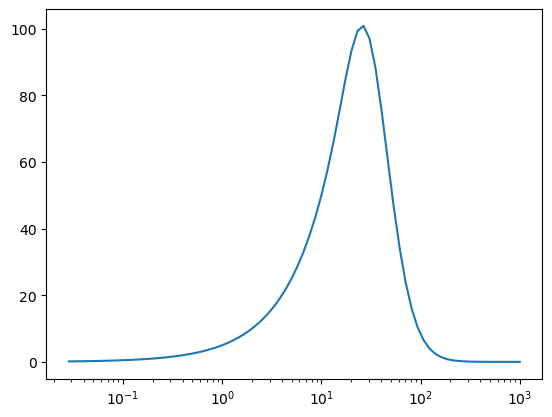

In [4]:
plt.plot(T_arr, expected_entropy)
plt.xscale("log")
plt

/home/coder/tmp/ipykernel_1471177/3851786577.py:50: RuntimeWarning: invalid value encountered in subtract
  term2 = r * np.exp(logiv(nu + 1, z) - logiv(nu, z))


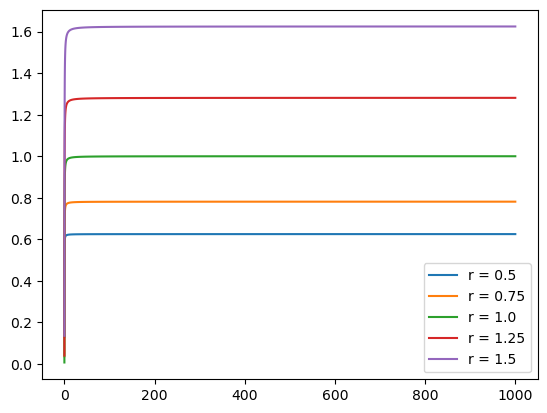

In [5]:
for r in np.linspace(0.5, 1.5, 5):
    plt.plot(T_arr, U(r, T_arr, 10), label=f"r = {r}")

plt.legend()

/home/coder/tmp/ipykernel_1471177/3851786577.py:50: RuntimeWarning: invalid value encountered in subtract
  term2 = r * np.exp(logiv(nu + 1, z) - logiv(nu, z))


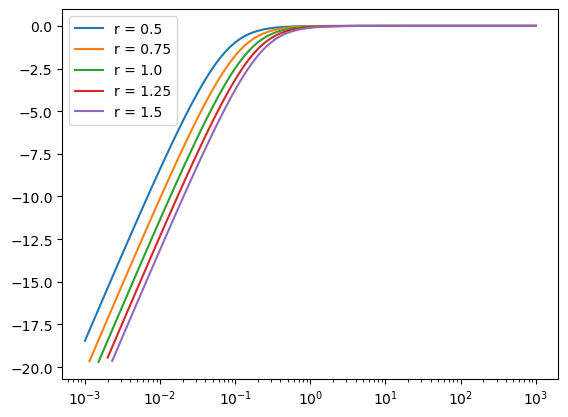

In [6]:
for r in np.linspace(0.5, 1.5, 5):
    plt.plot(T_arr, S(r, T_arr, 10), label=f"r = {r}")

plt.xscale("log")
# plt.yscale("log")
plt.legend()

/home/coder/tmp/ipykernel_1471177/3851786577.py:50: RuntimeWarning: invalid value encountered in subtract
  term2 = r * np.exp(logiv(nu + 1, z) - logiv(nu, z))


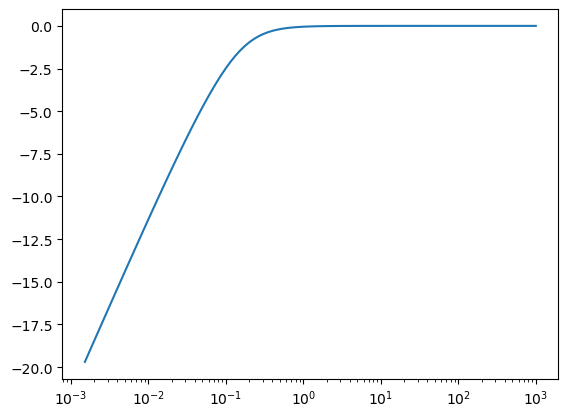

In [7]:
plt.plot(T_arr, S(1, T_arr, 10))

plt.xscale("log")
# plt.yscale("log")


/home/coder/tmp/ipykernel_1471177/2357904039.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  S_arr.append(quad(lambda r: p(r, T, 10) * S(r, T, 10), 0, 3 * np.sqrt(1 + T))[0])


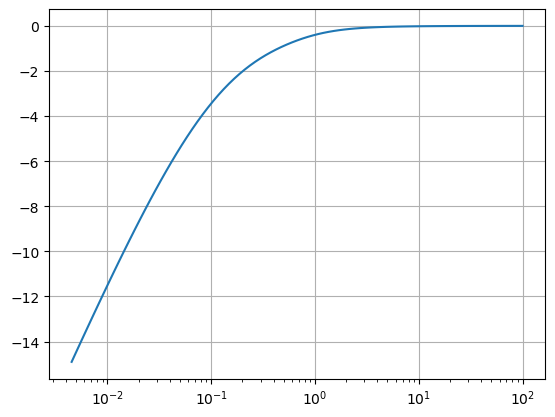

In [16]:
T_arr = np.logspace(-3, 2, 100)
S_arr = []
for T in T_arr:
    S_arr.append(quad(lambda r: p(r, T, 10) * S(r, T, 10), 0, 3 * np.sqrt(1 + T))[0])

plt.plot(T_arr, S_arr)

plt.xscale("log")
# plt.yscale("log")
plt.grid()


In [10]:
r_arr = np.logspace(-2, 2, 100)
T_arr = np.logspace(-2, 2, 100)

/home/coder/tmp/ipykernel_1471177/3851786577.py:50: RuntimeWarning: invalid value encountered in subtract
  term2 = r * np.exp(logiv(nu + 1, z) - logiv(nu, z))
/home/coder/tmp/ipykernel_1471177/2016625708.py:10: UserWarning: No contour levels were found within the data range.
  plt.contour(r_arr, T_arr, S_values, levels=[0], colors="red", linewidths=2, linestyles="dashed", label="S(r, T) = 0")
/home/coder/tmp/ipykernel_1471177/2016625708.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(r_arr, T_arr, S_values, levels=[0], colors="red", linewidths=2, linestyles="dashed", label="S(r, T) = 0")


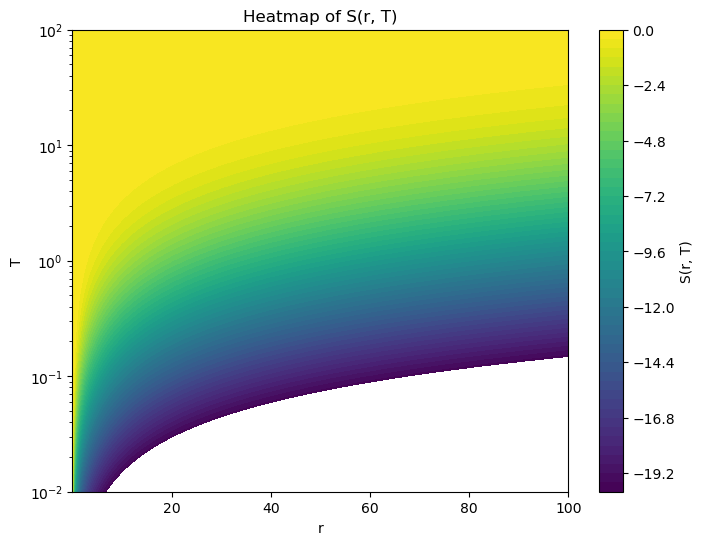

In [11]:
R, T = np.meshgrid(r_arr, T_arr)

# Evaluate S(r, T) on the grid
S_values = S(R, T, 10)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(r_arr, T_arr, S_values, levels=50, cmap="viridis")
plt.colorbar(label="S(r, T)")
plt.contour(r_arr, T_arr, S_values, levels=[0], colors="red", linewidths=2, linestyles="dashed", label="S(r, T) = 0")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("r")
plt.ylabel("T")
plt.title("Heatmap of S(r, T)")
plt.show()

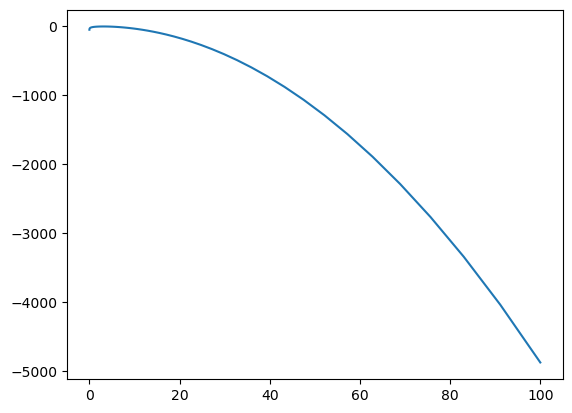

In [12]:
plt.plot(r_arr, logp(r_arr, 1, 10))

In [19]:
U_arr = []
for T in T_arr:
    U_arr.append(quad(lambda r: p(r, T, 10) * U(r, T, 10), 0, 3 * np.sqrt(1 + T))[0])

/home/coder/tmp/ipykernel_1471177/782241404.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  U_arr.append(quad(lambda r: p(r, T, 10) * U(r, T, 10), 0, 3 * np.sqrt(1 + T))[0])


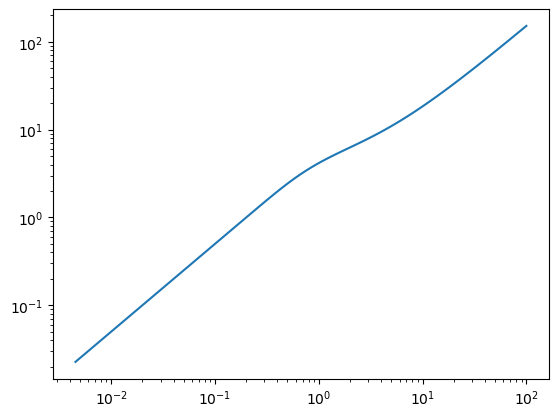

In [22]:
plt.plot(T_arr, U_arr)

plt.xscale("log")
plt.yscale("log")